
# **Tutorial on Causality**
## TACsy PhD School 2025
### Date: February 17, 2025 <br>
### Lecturer: Adèle Helena Ribeiro

## Setup



In [1]:
%load_ext rpy2.ipython

In [2]:
!apt-get install librsvg2-dev > /dev/null 2>&1



In [3]:
%ls "/usr/local/lib/R/site-library/"

abind/         CCP/          fastICA/      IRkernel/    mvtnorm/   Rcpp/           R.oo/     XML/
ape/           clue/         ggm/          jsonlite/    numDeriv/  RcppArmadillo/  R.rsp/    zoo/
bdsmatrix/     corpcor/      graph/        lavaan/      pbdZMQ/    RcppEigen/      rsvg/
BH/            dagitty/      htmlwidgets/  lmtest/      pbivnorm/  repr/           R.utils/
BiocGenerics/  decor/        huge/         __MACOSX/    pcalg/     rgl/            sfsmisc/
BiocManager/   DEoptimR/     igraph/       markdown/    quadprog/  Rgraphviz/      V8/
BiocVersion/   DOT/          igraphdata/   matrixcalc/  RBGL/      R.methodsS3/    vcd/
causaleffect/  fastDummies/  IRdisplay/    mnormt/      R.cache/   robustbase/     vdiffr/


In [4]:
!wget -c https://github.com/adele/Causality-Tutorial/raw/refs/heads/main/resources/Rpackages.zip -O Rpackages.zip
!file *.zip
!unzip -n Rpackages.zip -d /usr/local/lib/R/site-library/ > /dev/null 2>&1

--2025-02-17 15:44:01--  https://github.com/adele/Causality-Tutorial/raw/refs/heads/main/resources/Rpackages.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/adele/Causality-Tutorial/refs/heads/main/resources/Rpackages.zip [following]
--2025-02-17 15:44:02--  https://raw.githubusercontent.com/adele/Causality-Tutorial/refs/heads/main/resources/Rpackages.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 416 Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Rpackages.zip: Zip archive data, at least v2.0 to extract, compression method=store


In [5]:
%ls "/usr/local/lib/R/site-library/"

abind/         CCP/          fastICA/      IRkernel/    mvtnorm/   Rcpp/           R.oo/     XML/
ape/           clue/         ggm/          jsonlite/    numDeriv/  RcppArmadillo/  R.rsp/    zoo/
bdsmatrix/     corpcor/      graph/        lavaan/      pbdZMQ/    RcppEigen/      rsvg/
BH/            dagitty/      htmlwidgets/  lmtest/      pbivnorm/  repr/           R.utils/
BiocGenerics/  decor/        huge/         __MACOSX/    pcalg/     rgl/            sfsmisc/
BiocManager/   DEoptimR/     igraph/       markdown/    quadprog/  Rgraphviz/      V8/
BiocVersion/   DOT/          igraphdata/   matrixcalc/  RBGL/      R.methodsS3/    vcd/
causaleffect/  fastDummies/  IRdisplay/    mnormt/      R.cache/   robustbase/     vdiffr/


### Installing additional required packages

In [6]:
%%R
suppressWarnings(install.packages('rsvg', verbose=FALSE))


(as ‘lib’ is unspecified)







	‘/tmp/RtmpCRicK2/downloaded_packages’



### Loading libraries

In [7]:
%%R

library(pcalg, warn.conflicts=F, quietly=T)
library(dagitty, warn.conflicts=F, quietly=T)
library(MASS, warn.conflicts=F, quietly=T)
library(causaleffect, warn.conflicts=F, quietly=T)
library(igraph, warn.conflicts=F, quietly=T)
library(DOT, warn.conflicts=F, quietly=T)
library(devtools, warn.conflicts=F, quietly=T)
library(rsvg, warn.conflicts=F, quietly=T)

### Helper Functions

In [8]:
%%R

####################
# Helper Functions #
####################

# A <- f(Ua) = Ua
# D <- f(Ucd, Ud) = beta_D.Ucd * Ucd + Ud
# B <- f(A, D, Ub) = beta_B.A * A - beta_B.D * D + Ub
# C <- f(Ucd, B, Uc) = beta_C.B * B - beta_C.Ucd * Ucd + Uc
# betaList is a list with entries for:
# beta_D.Ucd, beta_B.A, beta_B.D, beta_C.Ucd, and beta_C.B
# if betaList is NULL, then coefficients are randomly selected
getIVSEM <- function(betaList=NULL) {
  allvars <- c("A", "B", "C", "D", "Ucd")
  p <- length(allvars)
  beta <- matrix(0, p, p)
  colnames(beta) <- rownames(beta) <- allvars
  topolOrd <- c( "Ucd", "A", "D", "B", "C")

  if (is.null(betaList)) {
    betaList <- as.list(sample(c(-1, 1), p, replace = T) * runif(p, 0.3, 0.7))
    names(betaList) <- c("beta_D.Ucd", "beta_B.A", "beta_B.D", "beta_C.Ucd", "beta_C.B")
  }

  beta["Ucd","D"] <- betaList$beta_D.Ucd; # coeff of Ucd in the function for d
  beta["A", "B"] <- betaList$beta_B.A; # coeff of a in the function for b
  beta["D", "B"] <- betaList$beta_B.D; # coeff of d in the function for b
  beta["Ucd", "C"] <- betaList$beta_C.Ucd; # coeff of Ucd in the function for c
  beta["B", "C"] <- betaList$beta_C.B; # coeff of b in the function for c

  # Note that beta is triangular, implying that the SEM is recursive (or acyclic)
  beta <- beta[topolOrd, topolOrd]
  lat <- c("Ucd")

  return(list(beta=beta, lat=lat))
}

# The SEM is constructed as
# Y = B Y + eps, where B == beta
# beta is a matrix of the coefficients for all variables (V and U)
# Y = BY + eps --> Y - BY = eps --> (I - B)Y = eps --> Y = (I -B)^{-1} eps
generateDatasetFromSEM <- function(beta, lat, N) {
  p <- ncol(beta)
  ident <- diag(1, p, p)
  colnames(ident) <- rownames(ident) <- colnames(beta)
  # Or, similarly,
  # Y = (I - Beta)^{-1} eps.
  # For Gaussian Y and errors eps independent from each other (we have all the Us),
  # we just need to simulate Y from a multivariate distribution
  # of mean zero and cov Sigma=I
  IminusBinv <- ginv(ident - beta)
  Sigma = t(IminusBinv) %*% ident %*% IminusBinv

  valR <- matrixcalc::is.symmetric.matrix(Sigma) &&
    matrixcalc::is.positive.definite(Sigma, tol=1e-8)
  if (!valR) {
    stop("This SEM generates a non-positive definite covariance matrix. Try another SEM.")
  }

  dat <-  MASS::mvrnorm(N, rep(0, p), Sigma, empirical = FALSE)
  dat <- as.data.frame(dat)
  colnames(dat) <- colnames(beta)
  head(dat)

  uvars <- which(colnames(dat) %in% lat)
  dat <- dat[,-uvars]

  return(dat)
}

# Randomly generate a linear SEM following a dagitty DAG, adag,
# and then draw samples from it.
generateDatasetFromDAG <- function(adag, N, ntries=30) {
  done <- FALSE
  tries <- 0
  obs.dat <- NULL
  while (!done && tries <= ntries) {
    done <- tryCatch(
      {
        obs.dat <- dagitty::simulateSEM(adag, b.lower = -0.6, b.upper = 0.6, N=N)
        R <- cor(obs.dat)
        valR <- matrixcalc::is.symmetric.matrix(R) &&
          matrixcalc::is.positive.definite(R, tol=1e-8)
        valR
      }, error=function(cond) {
        message(cond)
        FALSE
      })
    tries <- tries + 1
  }
  return(obs.dat)
}

dagittyOracleCI <- function(x, y, S, suffStat) {
  g <- suffStat$g
  labels <- names(g)
  if (dagitty::dseparated(g, labels[x], labels[y], labels[S])) {
    return(1)
  } else {
    return(0)
  }
}

# receives a dagitty g of type "dag" or "mag" and returns
# the true PAG as an pcalg fci object
getTruePAG <- function(g, verbose = FALSE) {
  indepTest <- dagittyOracleCI
  if (graphType(g) == "dag") {
    g <- dagitty::toMAG(g)
  }
  suffStat <- list(g=g)
  truePag <- pcalg::fci(suffStat,
                        indepTest = indepTest,
                        labels= names(suffStat$g), alpha = 0.9999,
                        verbose = verbose)
  return(truePag)
}



# A -> B -> C; B <- D <- Ucd -> C
getIVGraph <- function() {
  allvars <- c("A", "B", "C", "D", "Uab", "Ucd")
  p <- length(allvars)
  amat <- matrix(0, p, p)
  colnames(amat) <- rownames(amat) <- allvars
  amat["Uab","A"] <- 0; amat["A","Uab"] <- 1; # Uab -> a
  amat["Uab","B"] <- 0; amat["B","Uab"] <- 1; # Uab -> b
  amat["B","C"] <- 0; amat["C","B"] <- 1; # b -> c
  amat["D","B"] <- 0; amat["B","D"] <- 1; # d -> b
  amat["Ucd","C"] <- 0; amat["C","Ucd"] <- 1; # Ucd -> c
  amat["Ucd","D"] <- 0; amat["D","Ucd"] <- 1; # Ucd -> c

  lat <- c("Uab", "Ucd")
  adag <- pcalg::pcalg2dagitty(amat, colnames(amat), type="dag")
  dagitty::latents(adag) <- lat
  coordinates(adag) <- list( x=c(A=0.5, Uab=0.65, B=0.80, C=1, D=0.88, Ucd=1),
                        y=c(A=0.15, Uab=0.05, B=0.15, C=0.15, D=0, Ucd=0) )


  idag <- igraph_from_graphNel(as(t(amat), "graphNEL"), lat)

  return(list(amat.dagitty = adag, # adjacency matrix as a dagitty object
              amat.igraph = idag, # adjacency matrix as an igraph object
              amat.pcalg = amat  # adjacency matrix as a matrix using pcalg notation
              ))
}


# n: number of nodes
# e_prob: probability of having an edge between any two nodes
# l_prob: proportion of the nodes to be considered latent (unmeasured variables)
getRandomGraph <- function(n, e_prob, l_prob, force_nedges=TRUE)  {
  if (force_nedges) {
    min_nedges <- floor((n*(n-1)/2)*(e_prob * 1))
  } else {
    min_nedges <- 0
  }
  nedges <- 0
  while (nedges <= min_nedges) {
    dag <- pcalg::randomDAG(n, e_prob, V = paste0("V", sprintf(
      paste0("%0", nchar(n), "d"), seq(from = 1, to = n))))

    amat.dag <- (as(dag, "matrix") > 0) * 1
    adag <- pcalg::pcalg2dagitty(amat.dag, colnames(amat.dag), type="dag")
    lat <- sample(colnames(amat.dag), l_prob * n)

    dagitty::latents(adag) <- lat

    magg <- dagitty::toMAG(adag)
    nedges <- nrow(edges(magg))
  }

  return(adag)
}

# types can be: png, pdf, or svg
#' @importFrom rsvg rsvg_png
#' @importFrom DOT dot
#' @export renderAG
renderAG <- function(amat, output_folder=NULL, fileid=NULL, type="png",
                     width=NULL, height=NULL, labels=NULL, add_index=TRUE) {
  if (is.null(labels)) {
    labels <- colnames(amat)
  }

  if (is.null(output_folder)) {
    output_folder = "./tmp/"
  }

  if (!file.exists(output_folder)) {
    dir.create(output_folder, recursive = TRUE)
  }

  if (is.null(fileid)) {
    fileid <- "ag"
  }

  if (type == "png") {
    png_filename <- paste0(output_folder, fileid, ".png")
    if (is.null(width)) {
      width = 1024
    }
    if (is.null(height)) {
      height = 1024
    }
  } else if (type == "pdf") {
    pdf_filename <- paste0(output_folder, fileid, ".pdf")
    if (is.null(width)) {
      width = 5
    }
    if (is.null(height)) {
      height = 5
    }
  }

  dot_filename <- paste0(output_folder, fileid, ".dot")
  svg_filename <- paste0(output_folder, fileid, ".svg")

  graphFile <- file(dot_filename, "w")
  cat('digraph graphname {', file=graphFile)
  cat('node [shape = oval];\n', file=graphFile)

  formatted_labels <- labels
  if (add_index) {
    formatted_labels <- paste0(formatted_labels, "_", 1:length(labels))
  }

  for (v in formatted_labels) {
    cat(v, "[label=", v, "]\n", file=graphFile)
  }

  # For each row:
  for (i in 1:(nrow(amat)-1)) {
    # For each column:
    for (j in (i+1):ncol(amat)) {
      label_i <- formatted_labels[i]
      label_j <- formatted_labels[j]

      if (amat[i,j] > 0) {
        cat(label_i, "->", label_j, "[color=black, dir=both,",  file=graphFile)
        if (amat[i,j] == 1) {
          cat("arrowhead=odot, ", file=graphFile)
        } else if (amat[i,j] == 2) {
          cat("arrowhead=normal, ", file=graphFile)
        } else if (amat[i,j] == 3) {
          cat("arrowhead=none, ", file=graphFile)
        }

        if (amat[j,i] == 1) {
          cat("arrowtail=odot", file=graphFile)
        } else if (amat[j,i] == 2) {
          cat("arrowtail=normal", file=graphFile)
        } else if (amat[j,i] == 3) {
          cat("arrowtail=none", file=graphFile)
        }
        cat("];\n", file=graphFile)
      }
    }
  }
  cat("}\n", file=graphFile)
  close(graphFile)

  DOT::dot(paste(readLines(dot_filename), collapse=" "), file=svg_filename)

  if (type == "png") {
    rsvg::rsvg_png(svg_filename, png_filename, width = 1024, height = 1024)
  } else if (type == "pdf") {
    rsvg::rsvg_pdf(svg_filename, pdf_filename, width = 5, height = 5)
  }
}

igraph_from_graphNel <- function(graphN, latNodes){
  igraph_dag <- igraph::igraph.from.graphNEL(graphN, weight = FALSE)
  for (n in latNodes) {
    adj_list <- graphN@edgeL[[n]]$edges
    if (length(adj_list) == 2) {
      igraph_dag <- igraph::add_edges(igraph_dag, c(adj_list[1], adj_list[2], adj_list[2], adj_list[1]))
      igraph_dag <- igraph::set.edge.attribute(graph = igraph_dag,
                                               name ="description",
                                               index = c(length(igraph::E(igraph_dag))-1, length(igraph::E(igraph_dag))), value = "U")
    }
  }
  for (n in latNodes){
    igraph_dag <- igraph::delete_vertices(igraph_dag, n)
  }
  return(igraph_dag)
}

# returns an pcalg amat (adjacency matrix) of
# type amat.pag (same type for MAGs), where:
# 0: No edge
# 1: Circle
# 2: Arrowhead
# 3: Tail
dagitty2amat <- function(adagg, type="mag") {
  edg <- dagitty:::edges(adagg)
  node_names <- dagitty:::names.dagitty(adagg)
  ans_mat <- matrix(
    data = 0, nrow = length(node_names),
    ncol = length(node_names),
    dimnames = list(node_names, node_names)
  )

  diredg <- subset(edg, e == "->")

  ans_mat[as.matrix(diredg[c("w", "v")])] <- 3
  ans_mat[as.matrix(diredg[c("v", "w")])] <- 2

  bidiredg <-  subset(edg, e == "<->")
  ans_mat[as.matrix(bidiredg[c("w", "v")])] <- 2
  ans_mat[as.matrix(bidiredg[c("v", "w")])] <- 2

  return(ans_mat)
}



## **Part I: Causal Modeling and Effect Identification from Causal Diagrams**

### Model Definition

#### Structural Causal Model (SCM)

The SCM will be only used later for generating a dataset.

In [9]:
%%R

trueSCM <- getIVSEM()
trueSCM$beta # coefficient matrix of a linear SEM
trueSCM$lat # variables we will considered are not observed.

[1] "Ucd"


#### Causal Diagram

Plotting the graph corresponding to the SCM.

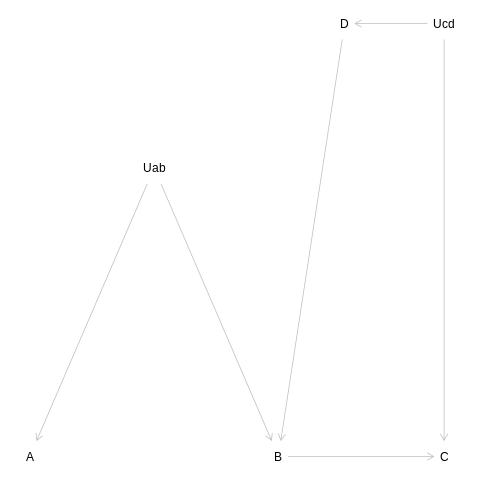

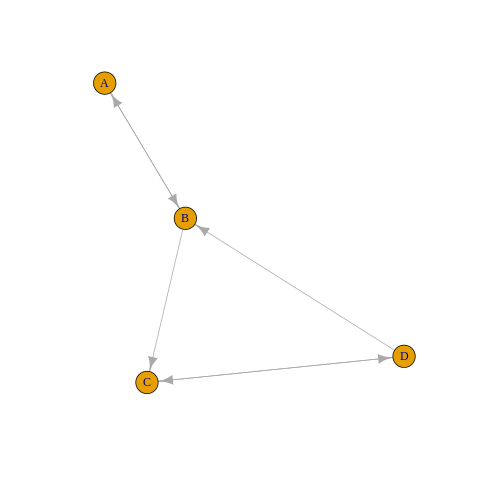

In [10]:
%%R

trueDAG_obj <- getIVGraph()
trueDAG <- trueDAG_obj$amat.dagitty # adjacency matrix as a dagitty object
trueDiagram <- trueDAG_obj$amat.igraph # adjacency matrix as an igraph object
plot(trueDAG) # showing the U variables
plot(trueDiagram) # bidirected edges represent hidden confounders


### Effect Identification given a Causal Diagram


#### Identification via Adjustment given a Causal Diagram

Checking identifiability of P(y\|do(x)) through generalized adjustment criterion (GAC).

In [11]:
%%R

x = 2 # index of variable "B"
y = 3 # index of variable "C"

trueMAG <- dagitty::toMAG(trueDAG) # graphical model without the latent confounders
                                   # we will see this later

trueMAG.pcalg <- dagitty2amat(trueMAG, type="mag")
labels <- colnames(trueMAG.pcalg)

adj <- pcalg::adjustment(amat = trueMAG.pcalg, amat.type = "mag",
                  x = x, y = y, set.type = "all")
if (length(adj) > 1) {
  print(paste0("P(", labels[y], "|do(", labels[x], ")) is identifiable via adjustment over:"))
  sapply(adj, function(x) { paste(labels[x], collapse=",") } ) # List of all sets admissible for adjustment
} else {
  print(paste0("P(", y, "|do(", x, ")) is not identifiable via adjustment."))
}



[1] "P(C|do(B)) is identifiable via adjustment over:"
[1] "D"   "A,D"


Checking whether a particular set is admissible for adjustment.

In [12]:
%%R

z <- c(1) # indices of the covariate set
zlabels <- labels[z]
print(paste0("Is the effect of ", labels[x], " on ", labels[y], " identifiable through adjustment over {", paste(zlabels, collapse=","), "}? "))


[1] "Is the effect of B on C identifiable through adjustment over {A}? "


In [13]:
%%R

gac_out <- pcalg::gac(trueMAG.pcalg, x, y, z, type = "mag")
is_admissible <- gac_out$gac

print(paste0("Answer: ", is_admissible))

[1] "Answer: FALSE"


#### Identification via ID Algorithm given a Causal Diagram


##### Marginal Causal Effect

In [14]:
%%R

y = "C"
x = "B" # Change to "D" to evaluate the effect of D on C

print(paste0("The marginal effect of ", x, " on ", y, ", P(", y, "|do(", x, ")), is identifiable via ID algorithm:"))

exprDAG <- causaleffect::causal.effect(y=y, x=x, z=c(),
                                       G = trueDiagram,
                                       expr = TRUE,
                                       simp = TRUE,
                                       steps = FALSE)
print(paste0("P(", y, "|do(", x, ")) = ", exprDAG))
# Note: to see all steps applied by the ID algorithm,
# use expr = FALSE and steps = TRUE.

[1] "The marginal effect of B on C, P(C|do(B)), is identifiable via ID algorithm:"
[1] "P(C|do(B)) = \\sum_{D}P(C|D,B)P(D)"


##### Conditional Causal Effect


In [15]:
%%R

y = "C"
x = "B"
z = c("D")

print(paste0("The conditional effect of ", x, " on ", y, " conditional on ", z, ", P(", y, "|do(", x, "), ", z, "), is identifiable via ID algorithm:"))

exprDAG <- causaleffect::causal.effect(y=y, x=x, z=z,
                                       G = trueDiagram,
                                       expr = TRUE,
                                       simp = TRUE,
                                       steps = FALSE)
print(paste0("P(", y, "|do(", x, "), ", z, ") = ", exprDAG))

[1] "The conditional effect of B on C conditional on D, P(C|do(B), D), is identifiable via ID algorithm:"
[1] "P(C|do(B), D) = P(C|D,B)"


### **Questions:**

1. Is the causal effect of D on C identifiable from the causal diagram? If so, how?
2. What can we do if no knowledge is available to construct a causal diagram?



## **Part II: Causal Discovery and Effect Identification from the Markov Equivalence Class**

#### Installing PAGId R Package -- For IDP and CIDP Algorithms

In [16]:
%%R

if (!require(PAGId)) {
  library(devtools, warn.conflicts=F, quietly=T)
  devtools::install_github("adele/PAGId", dependencies=TRUE)
}

library(PAGId)

These packages have more recent versions available.
It is recommended to update all of them.
Which would you like to update?

 1: All                                         
 2: CRAN packages only                          
 3: None                                        
 4: jsonlite     (1.8.8      -> 1.8.9   ) [CRAN]
 5: Rcpp         (1.0.12     -> 1.0.14  ) [CRAN]
 6: DEoptimR     (1.1-3      -> 1.1-3-1 ) [CRAN]
 7: cli          (3.6.3      -> 3.6.4   ) [CRAN]
 8: igraph       (2.0.3      -> 2.1.4   ) [CRAN]
 9: BiocManager  (1.30.23    -> 1.30.25 ) [CRAN]
10: V8           (4.4.2      -> 6.0.1   ) [CRAN]
11: RcppArmad... (0.12.8.4.0 -> 14.2.3-1) [CRAN]
12: clue         (0.3-65     -> 0.3-66  ) [CRAN]
13: fastICA      (1.2-4      -> 1.2-7   ) [CRAN]
14: sfsmisc      (1.1-18     -> 1.1-20  ) [CRAN]
15: vcd          (1.4-12     -> 1.4-13  ) [CRAN]
16: robustbase   (0.99-2     -> 0.99-4-1) [CRAN]
17: abind        (1.4-5      -> 1.4-8   ) [CRAN]
18: pcalg        (2.7-11     -> 2.7-12  )


(as ‘lib’ is unspecified)







	‘/tmp/RtmpCRicK2/downloaded_packages’



── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/RtmpCRicK2/remotes26be26b4348b/adele-PAGId-1dc096a/DESCRIPTION’ ... OK
* preparing ‘PAGId’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
Omitted ‘LazyData’ from DESCRIPTION
* building ‘PAGId_1.0.tar.gz’



(as ‘lib’ is unspecified)



#### Maximal Ancestral Graph (MAG)

Computing the MAG corresponding to the true causal diagram.

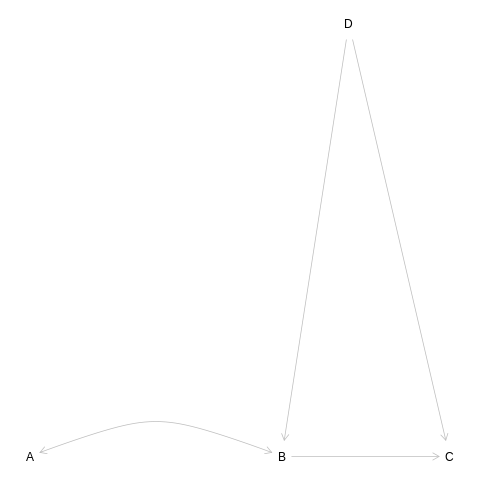

In [17]:
%%R

trueMAG <- dagitty::toMAG(trueDAG)
plot(trueMAG)

#### Implied Minimal Conditional Independencies

The conditional independencies (among observed variables) implied by a MAG through m-separations are the same as the conditional independencies (among the observed variables) implied from a causal diagram through d-separations.

Notably, MAGs preserve conditional independencies without explicitly encoding latent confounders.



In [18]:
%%R

trueImpliedCI <- dagitty::impliedConditionalIndependencies(trueMAG, type = "missing.edge")
trueImpliedCI

A _||_ C | B, D
A _||_ D


#### Partial Ancestral Graph (PAG)

The true PAG can be obtained by running the FCI with an oracle (i.e., conditional independencies are directly inferred from the true DAG using d-separation).

In [19]:
%%R

truePAG <- getTruePAG(trueDAG, verbose = TRUE)

Compute Skeleton
Order=0; remaining edges:12
x= 1  y= 2  S=  : pval = 0 
x= 1  y= 3  S=  : pval = 0 
x= 1  y= 4  S=  : pval = 1 
x= 2  y= 1  S=  : pval = 0 
x= 2  y= 3  S=  : pval = 0 
x= 2  y= 4  S=  : pval = 0 
x= 3  y= 1  S=  : pval = 0 
x= 3  y= 2  S=  : pval = 0 
x= 3  y= 4  S=  : pval = 0 
x= 4  y= 2  S=  : pval = 0 
x= 4  y= 3  S=  : pval = 0 
Order=1; remaining edges:10
x= 1  y= 2  S= 3 : pval = 0 
x= 1  y= 3  S= 2 : pval = 0 
x= 2  y= 1  S= 3 : pval = 0 
x= 2  y= 1  S= 4 : pval = 0 
x= 2  y= 3  S= 1 : pval = 0 
x= 2  y= 3  S= 4 : pval = 0 
x= 2  y= 4  S= 1 : pval = 0 
x= 2  y= 4  S= 3 : pval = 0 
x= 3  y= 1  S= 2 : pval = 0 
x= 3  y= 1  S= 4 : pval = 0 
x= 3  y= 2  S= 1 : pval = 0 
x= 3  y= 2  S= 4 : pval = 0 
x= 3  y= 4  S= 1 : pval = 0 
x= 3  y= 4  S= 2 : pval = 0 
x= 4  y= 2  S= 3 : pval = 0 
x= 4  y= 3  S= 2 : pval = 0 
Order=2; remaining edges:10
x= 2  y= 1  S= 3 4 : pval = 0 
x= 2  y= 3  S= 1 4 : pval = 0 
x= 2  y= 4  S= 1 3 : pval = 0 
x= 3  y= 1  S= 2 4 : pval = 1 
x= 

Plotting the true PAG

In [20]:
%%R

#plot(truePAG)
renderAG(truePAG@amat, fileid = "truePAG", add_index = FALSE)

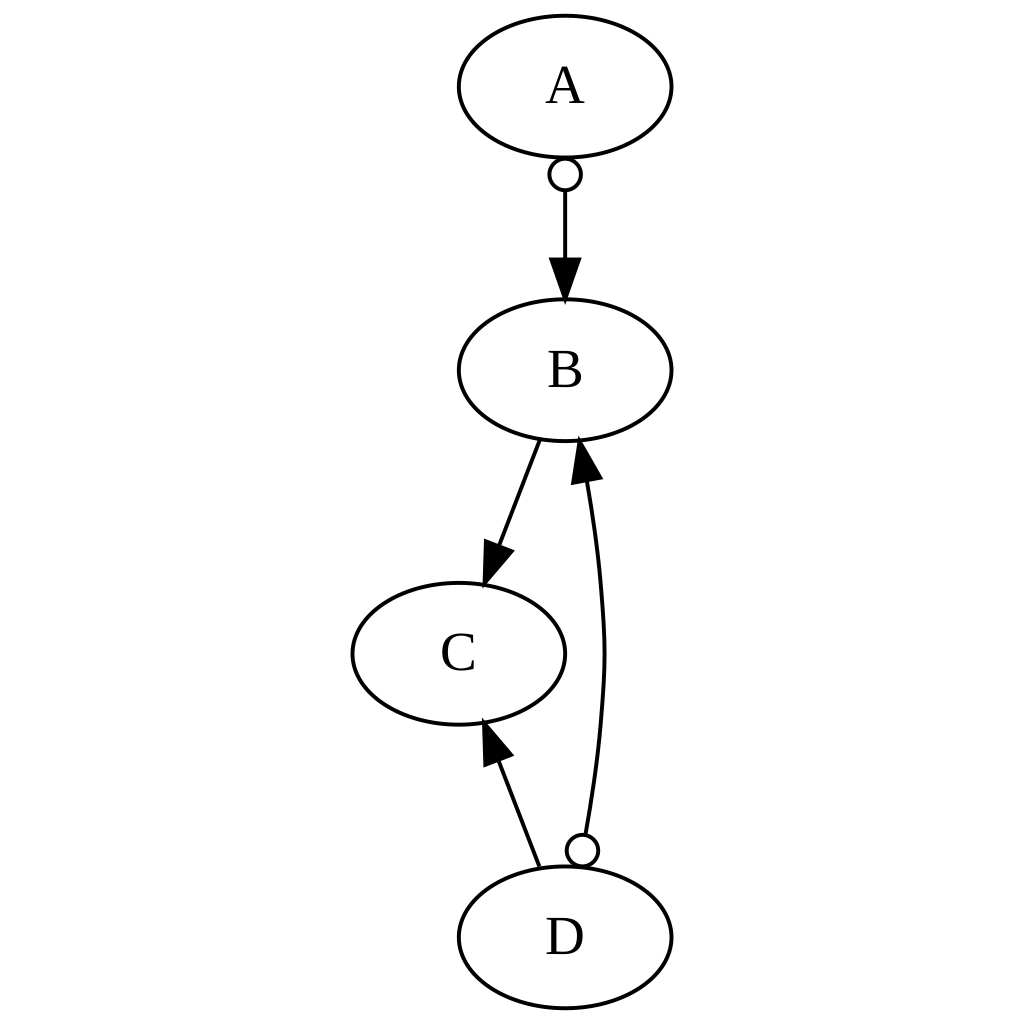

In [21]:
from IPython.display import Image
Image('tmp/truePAG.png', width=400, height=400)

### Causal Discovery

#### Data Generation from the True SCM

We are generating n=10000 samples.

In [22]:
%%R

n = 10000  # sample size
dat <- generateDatasetFromSEM(trueSCM$beta, trueSCM$lat, n)
dat <- dat[, c("A", "B", "C", "D")] # selecting only V={A, B, C, D}
head(dat)

             A          B          C          D
1  0.512459653  0.6587795 -1.4427065  0.9803582
2  1.041885418  0.4322414 -0.7644866 -0.7802852
3  0.008754558 -2.9170081  1.4738292 -2.0878924
4 -0.893626297  2.7724645  0.2413855 -1.3459444
5  0.530553027  0.4122685  0.2030382 -0.6939993
6 -0.836258268  1.9066414 -1.9117514  1.6810816


#### Inferring the PAG using FCI Algorithm

Since our variables follow a Gaussian distribution, the partial correlation test (Fisher's Z test) can be used to assess conditional independencies.

For other data types, appropriate conditional independence tests should be used.


In [23]:
%%R

indepTest <- pcalg::gaussCItest    # Fisher's Z test
alpha <- 0.05                      # Significance level of 5%
suffStat <- list(C = cor(dat), n = n)
estPAG <- pcalg::fci(suffStat,
                     indepTest = indepTest,
                     labels= colnames(dat), alpha = alpha,
                     verbose = TRUE)

Compute Skeleton
Order=0; remaining edges:12
x= 1  y= 2  S=  : pval = 1.716268e-158 
x= 1  y= 3  S=  : pval = 7.908424e-47 
x= 1  y= 4  S=  : pval = 0.3773542 
x= 2  y= 1  S=  : pval = 1.716268e-158 
x= 2  y= 3  S=  : pval = 0 
x= 2  y= 4  S=  : pval = 0 
x= 3  y= 1  S=  : pval = 7.908424e-47 
x= 3  y= 2  S=  : pval = 0 
x= 3  y= 4  S=  : pval = 1.539052e-06 
x= 4  y= 2  S=  : pval = 0 
x= 4  y= 3  S=  : pval = 1.539052e-06 
Order=1; remaining edges:10
x= 1  y= 2  S= 3 : pval = 3.058705e-118 
x= 1  y= 3  S= 2 : pval = 7.1433e-07 
x= 2  y= 1  S= 3 : pval = 3.058705e-118 
x= 2  y= 1  S= 4 : pval = 1.851964e-201 
x= 2  y= 3  S= 1 : pval = 7.608864e-300 
x= 2  y= 3  S= 4 : pval = 0 
x= 2  y= 4  S= 1 : pval = 0 
x= 2  y= 4  S= 3 : pval = 0 
x= 3  y= 1  S= 2 : pval = 7.1433e-07 
x= 3  y= 1  S= 4 : pval = 1.161552e-46 
x= 3  y= 2  S= 1 : pval = 7.608864e-300 
x= 3  y= 2  S= 4 : pval = 0 
x= 3  y= 4  S= 1 : pval = 2.264711e-06 
x= 3  y= 4  S= 2 : pval = 8.184542e-61 
x= 4  y= 2  S= 3 : pval = 

Plotting the estimated PAG

In [24]:
%%R

#plot(estPAG)
renderAG(estPAG@amat, fileid = "estimatedPAG", add_index = FALSE)

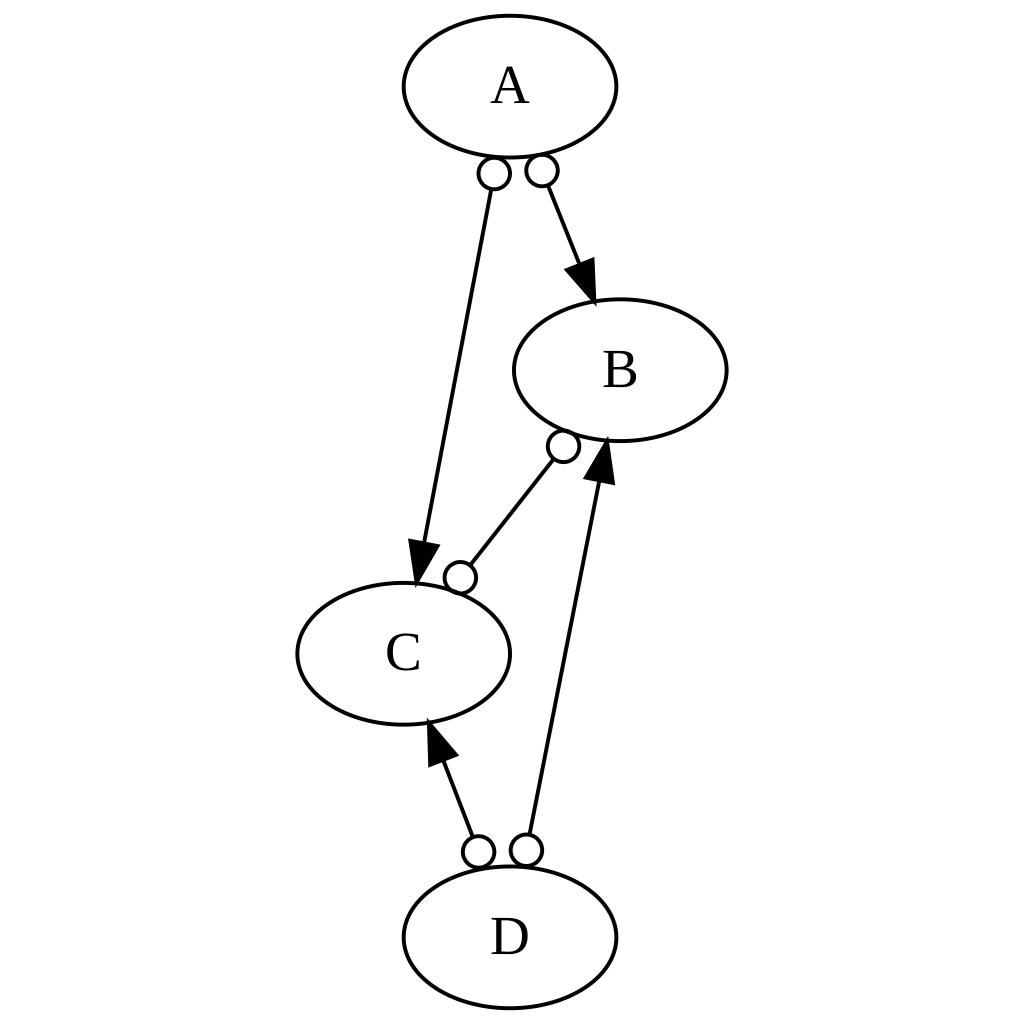

In [25]:
from IPython.display import Image
Image('tmp/estimatedPAG.png', width=400, height=400)

### Questions:

1.  Did we recover the correct PAG?
2.  What the inferred PAG tell us about the relationship between every pair of nodes?
3.  Is the true causal diagram a member of the PAG's Markov Equivalence Class?
4.  What can it happen with a smaller sample size?


### Effect Identification via Generalized Adjustment Criterion (GAC)

Checking identifiability of P(y\|do(x)) through generalized adjustment criterion (GAC).

In [26]:
%%R

labels <- colnames(estPAG@amat)
x = 2 # index of variable "B"
y = 3 # index of variable "C"

adj <- adjustment(amat = estPAG@amat, amat.type = "pag",
                  x = x, y = y, set.type = "all")

if (length(adj) > 1) {
  print(paste0("P(", y, "|do(", x, ")) is identifiable via adjustment over:"))
  sapply(adj, function(x) { paste(labels[x], collapse=",") } ) # List of all sets admissible for adjustment
} else {
  print(paste0("P(", y, "|do(", x, ")) is not identifiable via adjustment."))
}


[1] "P(3|do(2)) is not identifiable via adjustment."


Checking whether a particular set is admissible for adjustment.

In [27]:
%%R

z <- c(1) # indices of the covariate set c("A" "B" "C" "D")
zlabels <- labels[z]
print(paste0("Is the effect of ", labels[x], " on ", labels[y], " identifiable through adjustment over {", paste(zlabels, collapse=","), "}? "))


[1] "Is the effect of B on C identifiable through adjustment over {A}? "


In [28]:
%%R

gac_out <- gac(estPAG@amat, x, y, z, type = "pag")
is_admissible <- gac_out$gac

print(paste0("Answer: ", is_admissible))

[1] "Answer: FALSE"


### Effect Identification via CIDP Algorithm


#### Marginal Causal Effect

In [29]:
%%R

y = "C"
x = "B"
z = c()

retPAG <- CIDP(estPAG@amat, x, y, z, verbose = FALSE)

print(paste0("Is P(", y, "|do(", x, ")) identifiable? ", retPAG$id))
if (retPAG$id) {
  print(paste0("P(", y, "|do(", x, ")) = ", retPAG$Qexpr[[retPAG$query]]))
}

[1] "FAIL:  Error in identify(d, v): Q[A,C,D] is not identifiable from Q[A,B,C,D]\n"
[1] "Is P(C|do(B)) identifiable? FALSE"


In [30]:
%%R

# This shows the steps taken by the CIDP algorithm
# By substitution and simplication, we will get the same adjustment formula
 print(retPAG$Qexpr)

NULL


Note: IDP does not simiplifies the expression by leveraging conditional independences. By doing so, we would see the equivalence with the usual adjustment formula.



#### Conditional Causal Effect

In [31]:
%%R

y = "C"
x = "B"
z = c("A")

retPAG <- CIDP(estPAG@amat, x, y, z, verbose = FALSE)

print(paste0("Is P(", y, "|do(", x, "), ", z, ") identifiable? ", retPAG$id))
if (retPAG$id) {
  print(paste0("P(", y, "|do(", x, "), ", z, ") = ", retPAG$Qexpr[[retPAG$query]]))
}

[1] "Is P(C|do(B), A) identifiable? FALSE"


In [32]:
%%R

# This shows the steps taken by the CIDP algorithm
# By substitution and simplication, we will get the same adjustment formula
print(retPAG$Qexpr)

NULL


### Questions:

1.  Is the causal effect of D on C identifiable from the PAG? If so, how?